In [2]:
import os
import numpy as np
import pandas as pd
import datetime
import urllib
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sodapy import Socrata
 
from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict

In [3]:
client = Socrata("data.montgomeryal.gov", None)
results = client.get("pjb8-sd6v", limit=10000)
raw_data = pd.DataFrame.from_records(results)

In [4]:
#create copy of raw_data as data
data = raw_data

data = data.sort_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405 entries, 0 to 2404
Data columns (total 12 columns):
annual_salary      2405 non-null object
annualsalaryytd    2400 non-null object
department         2405 non-null object
grade              2405 non-null object
hire_date          2405 non-null object
name               2405 non-null object
otherpayamt        212 non-null object
otherpaydesc       1313 non-null object
overtimeamt        2311 non-null object
position_title     2405 non-null object
positiontype       2405 non-null object
step               2405 non-null object
dtypes: object(12)
memory usage: 225.5+ KB


In [5]:
#convert columns to appropriate types, data cleanup, and reset the index
cat_cols = pd.Index(['department', 'otherpaydesc', 'positiontype'])
#data[cat_cols] = data[cat_cols].apply(pd.Categorical)

data['otherpayamt'] = data['otherpayamt'].fillna(0) #replace null values with 0s
data['overtimeamt'] = data['overtimeamt'].fillna(0) #replace null values with 0s
data['hire_date'] = pd.to_datetime(data['hire_date'])

num_cols = pd.Index(['annual_salary', 'annualsalaryytd', 'otherpayamt', 'overtimeamt', 'step'])
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')

#data.set_index('hire_date', drop=False, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405 entries, 0 to 2404
Data columns (total 12 columns):
annual_salary      2405 non-null float64
annualsalaryytd    2400 non-null float64
department         2405 non-null object
grade              2405 non-null object
hire_date          2405 non-null datetime64[ns]
name               2405 non-null object
otherpayamt        2405 non-null float64
otherpaydesc       1313 non-null object
overtimeamt        2405 non-null float64
position_title     2405 non-null object
positiontype       2405 non-null object
step               2405 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 225.5+ KB


In [6]:
data.describe()

,annual_salary,annualsalaryytd,otherpayamt,overtimeamt,step
count,2405.000000,2400.000000,2405.000000,2405.000000,2405.000000
mean,40870.057148,5213.271962,157.859988,1181.408137,6.377131
std,15112.513225,2176.141613,759.279905,3403.729603,3.988281
min,6280.370000,79.360000,0.000000,0.000000,1.000000
25%,31343.520000,3729.007500,0.000000,0.000000,3.000000
50%,39500.990000,5025.920000,0.000000,0.000000,6.000000
75%,48204.370000,6299.805000,0.000000,619.890000,10.000000
max,150550.820000,17472.640000,10000.120000,57688.270000,15.000000


In [7]:
#create dictionary for departments by type and affix to dataframe
positions = data.department.unique()
types = ['Public Works', 'Public Safety', 'Maintenance/Sanitation', 
         'Public Works', 'Public Works', 'Maintenance/Sanitation', 
         'Public Safety', 'Public Safety', 'Public Works', 'Public Works', 
         'Admin & Judicial', 'Maintenance/Sanitation', 'Public Works', 
         'Admin & Judicial', 'Maintenance/Sanitation',  'Admin & Judicial', 'Admin & Judicial',
         'Maintenance/Sanitation', 'Public Safety', 'Admin & Judicial', 
         'Public Works', 'Admin & Judicial', 'Admin & Judicial', 
         'Admin & Judicial', 'Public Safety', 'Public Safety', 
         'Admin & Judicial', 'Admin & Judicial', 'Admin & Judicial', 
         'Admin & Judicial', 'Public Safety']
gov_dict = dict(zip(positions, types))
data['category'] = data['department'].map(gov_dict)
#data['category'] = pd.Categorical(data['category'])

In [8]:
#total of salary, overtime, and other payments to employees
data.groupby(['category'])['annual_salary', 'overtimeamt', 'otherpayamt'].sum()

,annual_salary,overtimeamt,otherpayamt
category,,,
Admin & Judicial,10048730.17,30406.96,21927.83
Maintenance/Sanitation,18183731.63,328372.92,692.31
Public Safety,53665512.40,2038115.29,347913.11
Public Works,16394513.24,444391.40,9120.02


In [9]:
#Mean salary
data.groupby(by='category')['annual_salary'].mean().to_frame()

,annual_salary
category,
Admin & Judicial,46307.512304
Maintenance/Sanitation,33364.645193
Public Safety,44241.972300
Public Works,38126.774977


In [10]:
#count of position types in the data
data.positiontype.value_counts().to_frame()

,positiontype
Full Time,1886
Full Time Exempt,382
Temporary,66
SCHOOL PATROL,46
Part Time,25


In [11]:
#create a dataframe with just fulltime employees
fulltime = data[~data['positiontype'].isin(["Temporary", "SCHOOL PATROL", "Part Time"])]

In [12]:
fulltime.describe()

,annual_salary,annualsalaryytd,otherpayamt,overtimeamt,step
count,2268.000000,2263.000000,2268.000000,2268.000000,2268.000000
mean,42289.129515,5416.532970,167.395622,1249.526601,6.490300
std,14107.915816,2029.823045,780.864023,3493.273224,3.910037
min,18000.000000,1040.100000,0.000000,0.000000,1.000000
25%,32838.210000,3938.395000,0.000000,0.000000,3.000000
50%,40676.690000,5176.770000,0.000000,0.000000,6.000000
75%,48672.572500,6406.045000,0.000000,714.970000,10.000000
max,150550.820000,17472.640000,10000.120000,57688.270000,15.000000


In [13]:
fulltime.pivot_table(values='annual_salary', index='category', aggfunc=np.mean)

,annual_salary
category,
Admin & Judicial,46116.251549
Maintenance/Sanitation,33943.650661
Public Safety,45690.848129
Public Works,40989.653324


In [14]:
#remove outliers from the dataframe
q75, q25 = np.percentile(fulltime['annual_salary'], [75,25])
print(q75, q25)

#annual salary outliers
ann_sal_fulltime = fulltime[['name', 'category', 'department', 'position_title', 'annual_salary', 'positiontype']][(fulltime['category'] == "Admin & Judicial") & ((fulltime['annual_salary'] > q75) | (fulltime['annual_salary'] < q25))]

48672.5725 32838.21


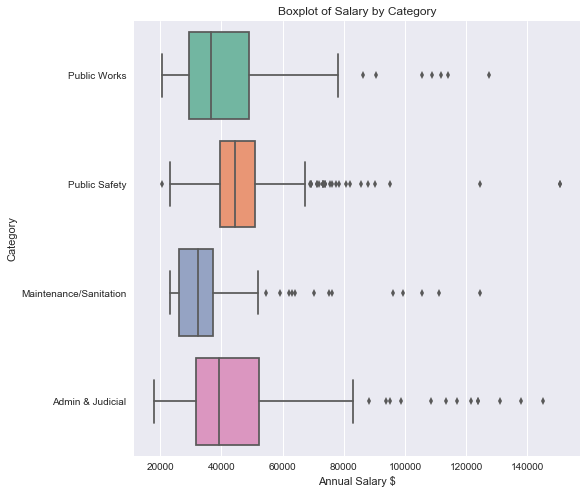

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(x='annual_salary', y='category', palette="Set2",
            data=fulltime)
ax.set(title='Boxplot of Salary by Category', ylabel='Category', xlabel='Annual Salary $')
plt.show()

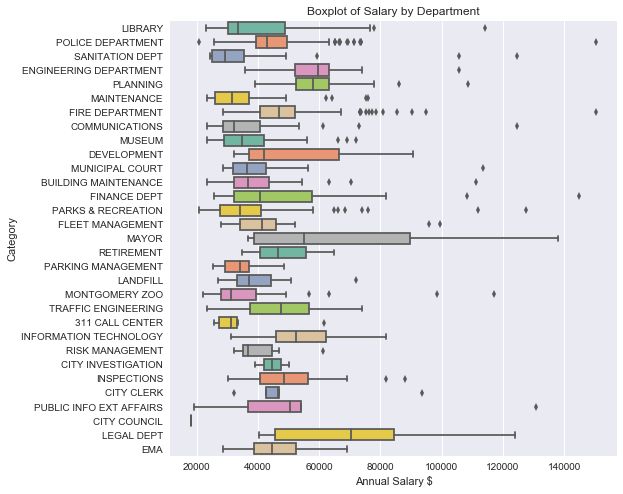

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(x='annual_salary', y='department', palette="Set2",
            data=fulltime)
ax.set(title='Boxplot of Salary by Department', ylabel='Category', xlabel='Annual Salary $')
plt.show()

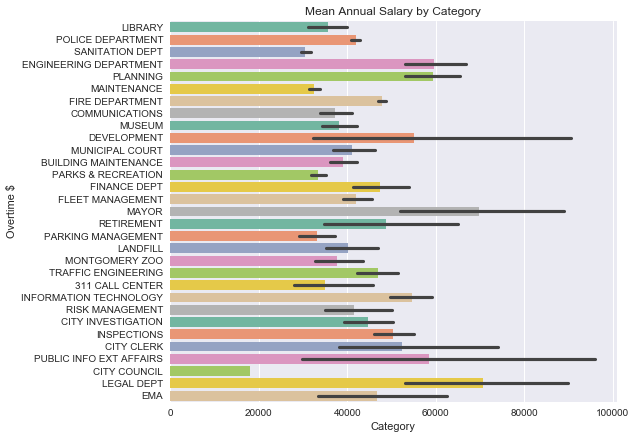

In [17]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(y='department', x='annual_salary', data=data, palette="Set2")
ax.set(title="Mean Annual Salary by Category", xlabel="Category", ylabel="Overtime $")
plt.show()

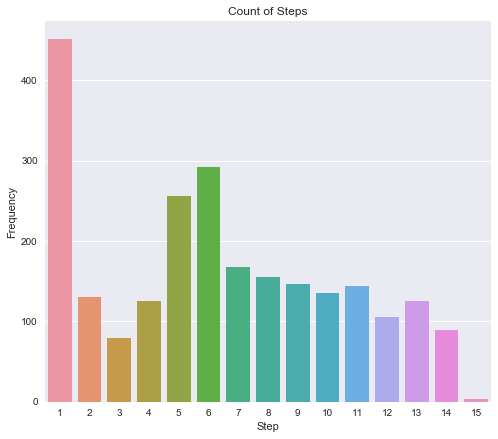

In [18]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.countplot(data.step)
ax.set(title="Count of Steps", xlabel='Step', ylabel='Frequency')
plt.show()

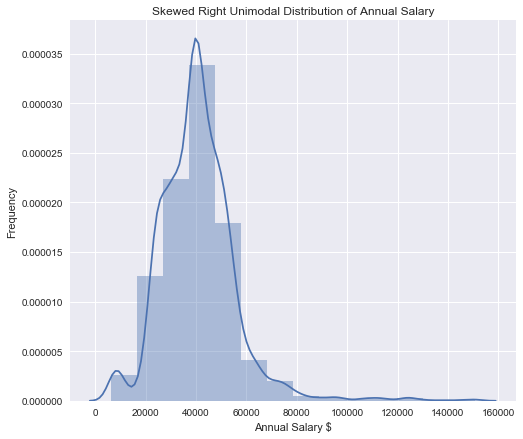

In [19]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.distplot(data['annual_salary'], bins=14)
ax.set(title="Skewed Right Unimodal Distribution of Annual Salary", 
       xlabel='Annual Salary $', ylabel='Frequency')
plt.show()

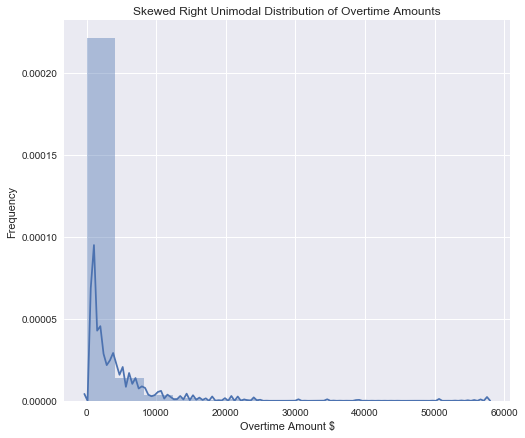

In [20]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.distplot(data['overtimeamt'], bins=14)
ax.set(title="Skewed Right Unimodal Distribution of Overtime Amounts", 
       xlabel="Overtime Amount $", ylabel="Frequency")
plt.show()

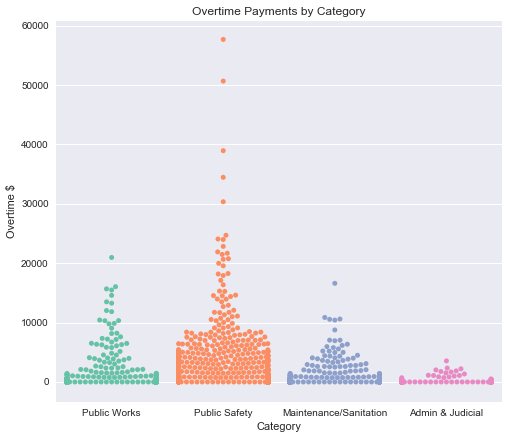

In [21]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.swarmplot(x='category', y='overtimeamt', data=data,  palette="Set2")
ax.set(title="Overtime Payments by Category", xlabel="Category", ylabel="Overtime $")
plt.show()

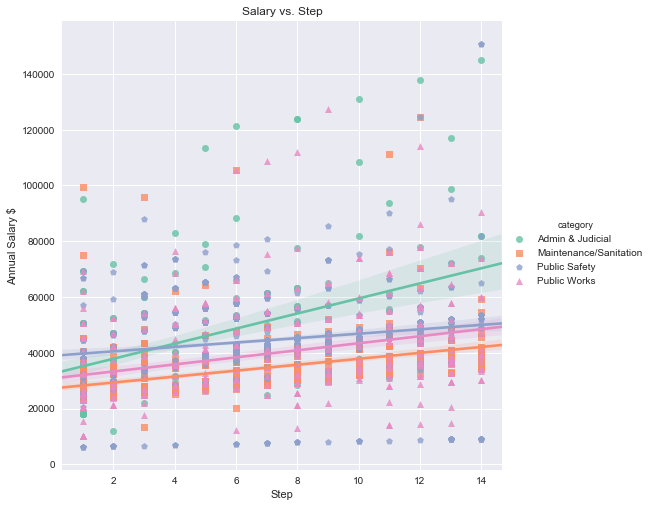

In [22]:
ax = sns.pairplot(x_vars='step', y_vars='annual_salary', hue='category', 
                  palette="Set2", markers=["o", "s", "p", "^"],
                  kind="reg", size=7,
                  data=data[data['positiontype'] != "Temporary"],)
ax.set(title="Salary vs. Step", xlabel='Step', ylabel='Annual Salary $')
plt.show()

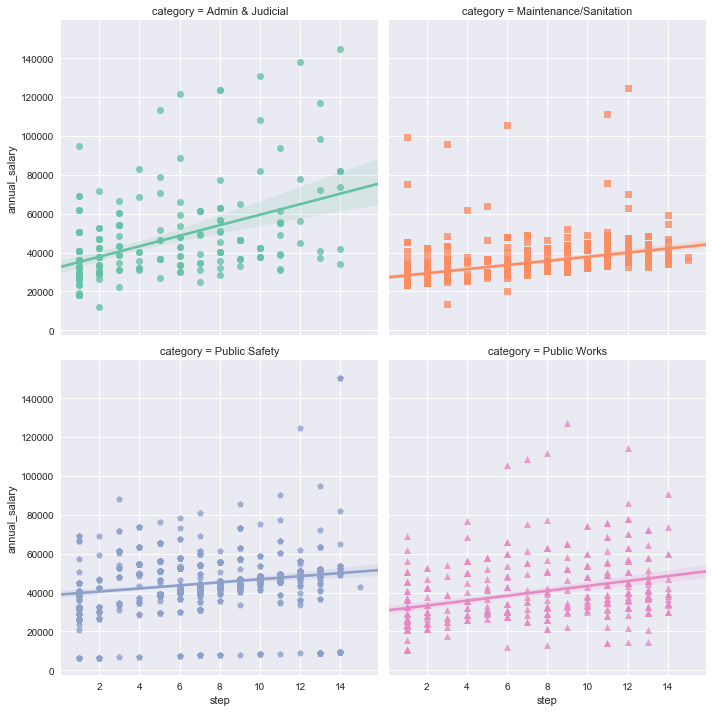

In [23]:
sns.lmplot(x='step', y='annual_salary', col='category', col_wrap=2,
           hue='category', palette="Set2", markers=["o", "s", "p", "^"],
           data=data[data['positiontype'] != "Temporary"])
plt.show()

In [24]:
#top 20 salaries
data[['name', 'position_title', 'category', 'annual_salary']].nlargest(20, columns='annual_salary')

,name,position_title,category,annual_salary
hire_date,,,,
2015-01-16,"FINLEY JR, ERNEST N",POLICE CHIEF,Public Safety,150550.82
1985-07-16,"JORDAN, MIFORD",FIRE CHIEF,Public Safety,150550.82
2013-09-27,"CRABB, BARRY O",DIRECTOR OF FINANCE,Admin & Judicial,144948.54
2015-07-03,"MCLEOD JR, PURSER L.",EXECUTIVE ASSISTANT TO MAYOR,Admin & Judicial,137934.78
2004-11-22,"BRIDDELL, MICHAEL S",DIR OF PUBLIC INFO&EXT AFFAIRS,Admin & Judicial,130921.23
1981-06-25,"MILLER, FRANKLIN S",DIRECTOR OF LEISURE SERVICES,Public Works,127414.35
2007-06-04,"FISHER, LARRY J",DIRECTOR OF EMERGENCY COMM,Public Safety,124525.65
1977-12-23,"DICKEY, DANIEL R",DIRECTOR SANITATION,Maintenance/Sanitation,124525.65
2001-10-09,"FEHL, KIMBERLY O",CITY ATTORNEY,Admin & Judicial,123907.47


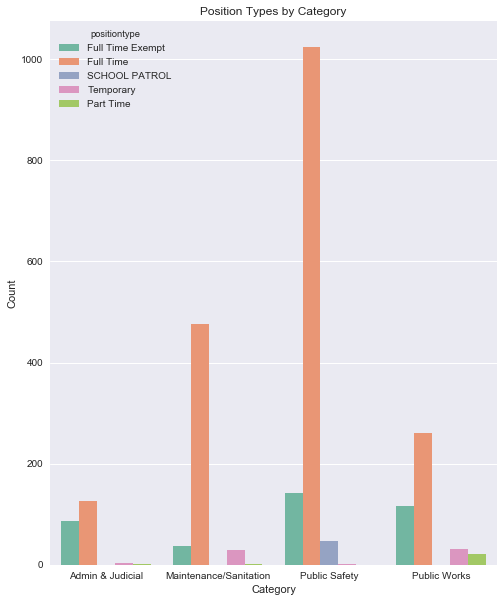

In [25]:
fig, ax = plt.subplots(figsize=(8,10))
ax = sns.countplot(x='category', hue='positiontype', data=data,  palette="Set2")
ax.set(title="Position Types by Category", xlabel="Category", ylabel="Count")
plt.show()

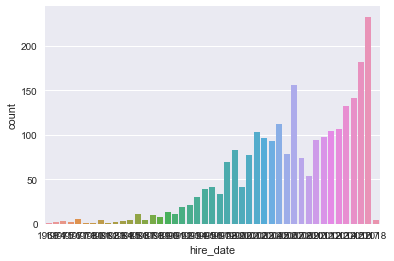

In [26]:
sns.countplot(data.index.year)
plt.show()

In [27]:
#the vast majority of employees are hired on Friday
data.index.dayofweek.value_counts()

4    2214
0     113
1      30
3      23
2      21
5       2
6       2
Name: hire_date, dtype: int64

In [28]:
data['2015' :'2017'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 557 entries, 2015-12-18 to 2016-09-09
Data columns (total 13 columns):
annual_salary      557 non-null float64
annualsalaryytd    556 non-null float64
department         557 non-null object
grade              557 non-null object
hire_date          557 non-null datetime64[ns]
name               557 non-null object
otherpayamt        557 non-null float64
otherpaydesc       287 non-null object
overtimeamt        557 non-null float64
position_title     557 non-null object
positiontype       557 non-null object
step               557 non-null int64
category           557 non-null category
dtypes: category(1), datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 57.3+ KB


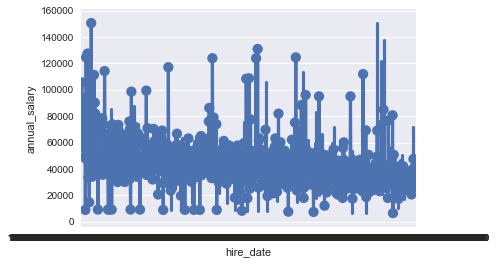

In [29]:
sns.pointplot('hire_date', 'annual_salary', data=data)
plt.show()

In [30]:
data['annual_salary'].mean()-data['annual_salary'].std()

25757.543922125747

In [31]:
data["department"].value_counts()

POLICE DEPARTMENT          631
FIRE DEPARTMENT            477
SANITATION DEPT            247
PARKS & RECREATION         241
MAINTENANCE                166
LIBRARY                     70
BUILDING MAINTENANCE        64
FLEET MANAGEMENT            55
COMMUNICATIONS              55
FINANCE DEPT                49
MUNICIPAL COURT             45
MONTGOMERY ZOO              40
MUSEUM                      38
TRAFFIC ENGINEERING         34
INSPECTIONS                 30
INFORMATION TECHNOLOGY      28
PLANNING                    27
ENGINEERING DEPARTMENT      17
MAYOR                       14
LANDFILL                    14
PARKING MANAGEMENT          13
CITY COUNCIL                 8
LEGAL DEPT                   8
RISK MANAGEMENT              6
311 CALL CENTER              6
CITY CLERK                   5
PUBLIC INFO EXT AFFAIRS      5
EMA                          4
RETIREMENT                   3
DEVELOPMENT                  3
CITY INVESTIGATION           2
Name: department, dtype: int64

In [32]:
pd.Series(gov_dict)

311 CALL CENTER                  Admin & Judicial
BUILDING MAINTENANCE       Maintenance/Sanitation
CITY CLERK                       Admin & Judicial
CITY COUNCIL                     Admin & Judicial
CITY INVESTIGATION                  Public Safety
COMMUNICATIONS                      Public Safety
DEVELOPMENT                          Public Works
EMA                                 Public Safety
ENGINEERING DEPARTMENT               Public Works
FINANCE DEPT                     Admin & Judicial
FIRE DEPARTMENT                     Public Safety
FLEET MANAGEMENT           Maintenance/Sanitation
INFORMATION TECHNOLOGY           Admin & Judicial
INSPECTIONS                         Public Safety
LANDFILL                            Public Safety
LEGAL DEPT                       Admin & Judicial
LIBRARY                              Public Works
MAINTENANCE                Maintenance/Sanitation
MAYOR                            Admin & Judicial
MONTGOMERY ZOO                   Admin & Judicial


In [33]:
#drop extra columns
columns = ["annual_salary", "department", "grade", "hire_date", "name", "position_title", "positiontype", "step"]
df = data[columns]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2405 entries, 2009-05-29 to 2007-10-05
Data columns (total 8 columns):
annual_salary     2405 non-null float64
department        2405 non-null object
grade             2405 non-null object
hire_date         2405 non-null datetime64[ns]
name              2405 non-null object
position_title    2405 non-null object
positiontype      2405 non-null object
step              2405 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 249.1+ KB


In [35]:
df.groupby(by=['department']).mean()

,annual_salary,step
department,,
311 CALL CENTER,34869.153333,5.000000
BUILDING MAINTENANCE,39041.758906,6.375000
CITY CLERK,52429.728000,6.600000
CITY COUNCIL,18000.000000,1.000000
CITY INVESTIGATION,44706.790000,5.500000
COMMUNICATIONS,37153.660000,2.963636
DEVELOPMENT,55015.306667,5.666667
EMA,46786.117500,1.500000
ENGINEERING DEPARTMENT,59618.942353,7.823529


In [36]:
df[['grade', 'position_title', 'annual_salary']].sort_values(by=["grade", "annual_salary"])

,grade,position_title,annual_salary
hire_date,,,
2000-01-03,340,MUNICIPAL JUDGE,38463.98
2016-02-29,700,ASST MUNICIPAL JUDGE,80641.18
2012-07-09,700,ASST MUNICIPAL JUDGE,95000.05
2003-11-11,888,COUNCIL MEMBER,18000.00
2007-11-13,888,COUNCIL MEMBER,18000.00
2009-01-05,888,COUNCIL MEMBER,18000.00
2015-11-10,888,COUNCIL MEMBER,18000.00
2015-11-10,888,COUNCIL MEMBER,18000.00
2011-11-08,888,COUNCIL MEMBER,18000.00


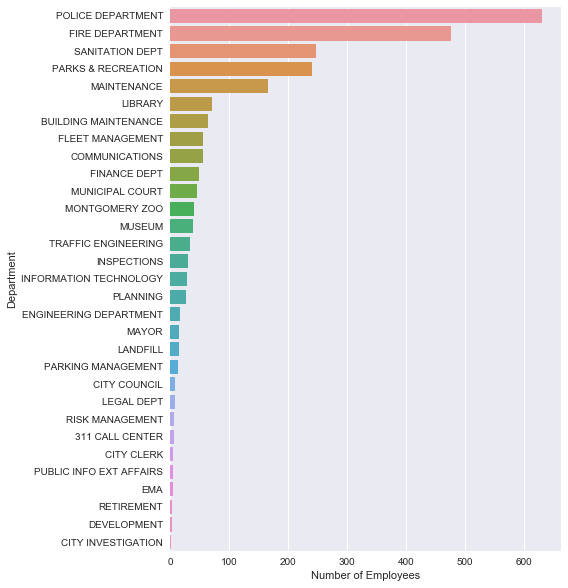

In [37]:
fig, ax = plt.subplots(figsize=(7,10))
ax = sns.countplot(y='department', data=data,
                  order = data['department'].value_counts().index)
plt.xlabel("Number of Employees")
plt.ylabel("Department")
plt.show()

# Salary Model

Intercept = [ 2.86745529]

Coefficient value of annual salary = [[  8.58740099e-05]]



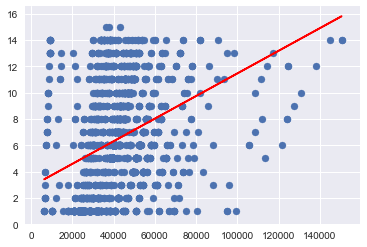

In [38]:
from sklearn import linear_model
X = data['annual_salary']
y = data['step']
lm = linear_model.LinearRegression()
lm.fit(X.values.reshape(-1,1),y.values.reshape(-1,1))
print('Intercept = ' + str(lm.intercept_) +'\n')
print('Coefficient value of annual salary = ' + str(lm.coef_) +'\n')
fig, ax = plt.subplots(1,1)
ax.plot(X.values.reshape(-1,1), lm.predict(X.values.reshape(-1,1)), color='red')
ax.scatter(X,y)
plt.show()

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [40]:
# categorical encoder function below

In [41]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [42]:
num_attribs = ["step"]
cat_attribs = ["department", "grade", "position_title", "positiontype", "category"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [43]:
X = data.drop(['annualsalaryytd', 'name', 'otherpayamt', 'otherpaydesc', 'overtimeamt', 'hire_date', 'annual_salary'], axis=1)
y = data[["annual_salary"]]

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405 entries, 0 to 2404
Data columns (total 6 columns):
department        2405 non-null object
grade             2405 non-null object
position_title    2405 non-null object
positiontype      2405 non-null object
step              2405 non-null int64
category          2405 non-null object
dtypes: int64(1), object(5)
memory usage: 112.8+ KB


In [45]:
X_transformed = full_pipeline.fit_transform(X)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)

In [268]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [269]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_train, lin_reg.predict(X_train))
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1003.2107461290498

In [270]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_test, lin_reg.predict(X_test))
lin_mae

26733277047358.172

In [217]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_scores = cross_val_score(lin_reg, X_train, y_train.values,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  1.12511051e+12   2.97520510e+13   3.59127124e+14   5.66637161e+12
   6.79778874e+13   6.56211543e+13   7.48955694e+13   2.62721111e+13
   4.84692135e+13   3.38897208e+13]
Mean: 7.12796313955e+13
Standard deviation: 9.88976582359e+13


In [218]:
from sklearn.model_selection import GridSearchCV

In [219]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lin_reg, parameters, cv=None)
grid.fit(X_train, y_train)

predictions = lin_reg.predict(X_test)
print("r2/variance : ", lin_reg.score(X_test, y_test))
print("Residual sum of squares: %.2f"
              % np.mean((lin_reg.predict(X_test) - y_test) ** 2))

r2/variance :  -2.52821285125e+20
Residual sum of squares: 56043099875564615923895631872.00


In [220]:
print("r2/variance : ", lin_reg.score(X_train, y_train))
print("Residual sum of squares: %.2f"
              % np.mean((lin_reg.predict(X_train) - y_train) ** 2))

r2/variance :  0.995621044238
Residual sum of squares: 1006431.80


In [221]:
X.iloc[17]

department            FIRE DEPARTMENT
grade                             PSE
position_title    DISTRICT FIRE CHIEF
positiontype         Full Time Exempt
step                                5
category                Public Safety
Name: 17, dtype: object

In [222]:
pred = pd.DataFrame(np.int64(lin_reg.predict(X_test)))
pred.iloc[17]

0    3648648306793169
Name: 17, dtype: int64

In [234]:
data.iloc[218]

annual_salary                  50251.8
annualsalaryytd                5798.29
department          CITY INVESTIGATION
grade                              A08
hire_date          2017-02-24 00:00:00
name               BAROUSSE, WILLIAM M
otherpayamt                          0
otherpaydesc                       NaN
overtimeamt                          0
position_title       CITY INVESTIGATOR
positiontype                 Full Time
step                                 4
category                 Public Safety
Name: 218, dtype: object

In [252]:
X.iloc[217:220]

,department,grade,position_title,positiontype,step,category
217,LIBRARY,A02,LIBRARY ASSISTANT I,Full Time,2,Public Works
218,CITY INVESTIGATION,A08,CITY INVESTIGATOR,Full Time,4,Public Safety
219,FIRE DEPARTMENT,PSC,FIRE LIEUTENANT,Full Time,5,Public Safety


In [223]:
np.int64(predictions[:18,:])

array([[           47000],
       [           42786],
       [           51700],
       [           38750],
       [           32328],
       [           40764],
       [           57344],
       [           35000],
       [           40956],
       [           65972],
       [           17996],
       [           55156],
       [           32328],
       [           34350],
       [           39752],
       [           39752],
       [           30862],
       [3648648306793169]], dtype=int64)

In [224]:
y_test.annual_salary[:18]

2179    46946.39
1525    43117.57
1377    50968.74
2372    38316.10
1125    32318.00
1697    40676.69
1973    57911.24
1027    34567.10
929     40894.26
210     63243.98
1517    18000.00
1724    54436.30
927     32318.00
2028    34599.34
1908    39456.35
56      39456.35
1938    29955.95
218     50251.76
Name: annual_salary, dtype: float64

In [251]:
np.int64(predictions[predictions > 100000])

array([3648648306793169,  501657389636718,  204308003832076,
        362203272752576,  148646797450848,  531759283181806,
        810146622780488,  126507333563580,  112315044860664,
        124037929727802, 3404910027367682,  140702391195092,
        142865723163136,  367124902293216,   37599604068786,
        353282952104588,   83976134949632,   37599604072476,
         82436114160374,  205494723302810,  154439826562456], dtype=int64)

In [33]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X_transformed)

NameError: name 'save_fig' is not defined

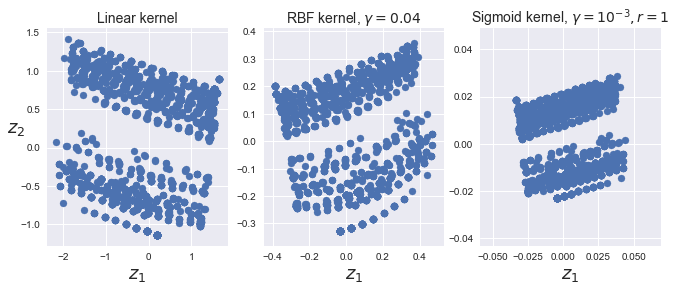

In [51]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

#y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X_transformed)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

In [35]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [48]:
X_transformed

array([[-1.34851326,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.84693974,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.09457946,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [-0.09457946,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.91171463,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.90856759,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])